In [1]:
import arviz as az
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [3]:
# Generate some data
np.random.seed(42)
n_inliers = 100
n_outliers = 10

In [4]:
# Inliers follow a normal distribution
mu_inlier, sigma_inlier = 0, 1
inliers = np.random.normal(mu_inlier, sigma_inlier, size=n_inliers)

In [5]:
# Outliers follow a different normal distribution
mu_outlier, sigma_outlier = 5, 1
outliers = np.random.normal(mu_outlier, sigma_outlier, size=n_outliers)

In [6]:
# Combine inliers and outliers
data = np.concatenate([inliers, outliers])

In [7]:
# Bayesian model for outlier detection
with pm.Model() as model:
    # Priors for mixture components (weights)
    pi = pm.Beta('pi', alpha=1, beta=1)  # Mixture proportion
    
    # Priors for inlier Gaussian
    mu_in = pm.Normal('mu_in', mu=0, sigma=10)
    sigma_in = pm.HalfNormal('sigma_in', sigma=10)
    
    # Priors for outlier Gaussian
    mu_out = pm.Normal('mu_out', mu=5, sigma=10)
    sigma_out = pm.HalfNormal('sigma_out', sigma=10)
    
    # Likelihood of data given mixture components
    # Inlier and outlier distributions
    inlier_dist = pm.Normal.dist(mu=mu_in, sigma=sigma_in)
    outlier_dist = pm.Normal.dist(mu=mu_out, sigma=sigma_out)
    
    # Mixture model
    mixture = pm.Mixture('mixture', w=[pi, 1 - pi], comp_dists=[inlier_dist, outlier_dist], observed=data)
    
    # Perform inference using MCMC
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi, mu_in, sigma_in, mu_out, sigma_out]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


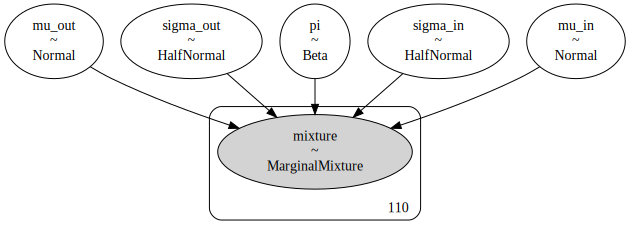

In [8]:
pm.model_to_graphviz(model)

In [9]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [10]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_in,-0.11,0.09,-0.28,0.07,0.00,0.00,3545.55,2868.96,1.0
mu_out,4.77,0.62,3.54,5.83,0.02,0.02,1288.45,625.99,1.0
pi,0.90,0.03,0.84,0.95,0.00,0.00,1556.57,1313.17,1.0
sigma_in,0.92,0.07,0.80,1.05,0.00,0.00,2755.84,2364.72,1.0
sigma_out,1.21,0.57,0.56,2.33,0.02,0.02,1030.62,957.48,1.0


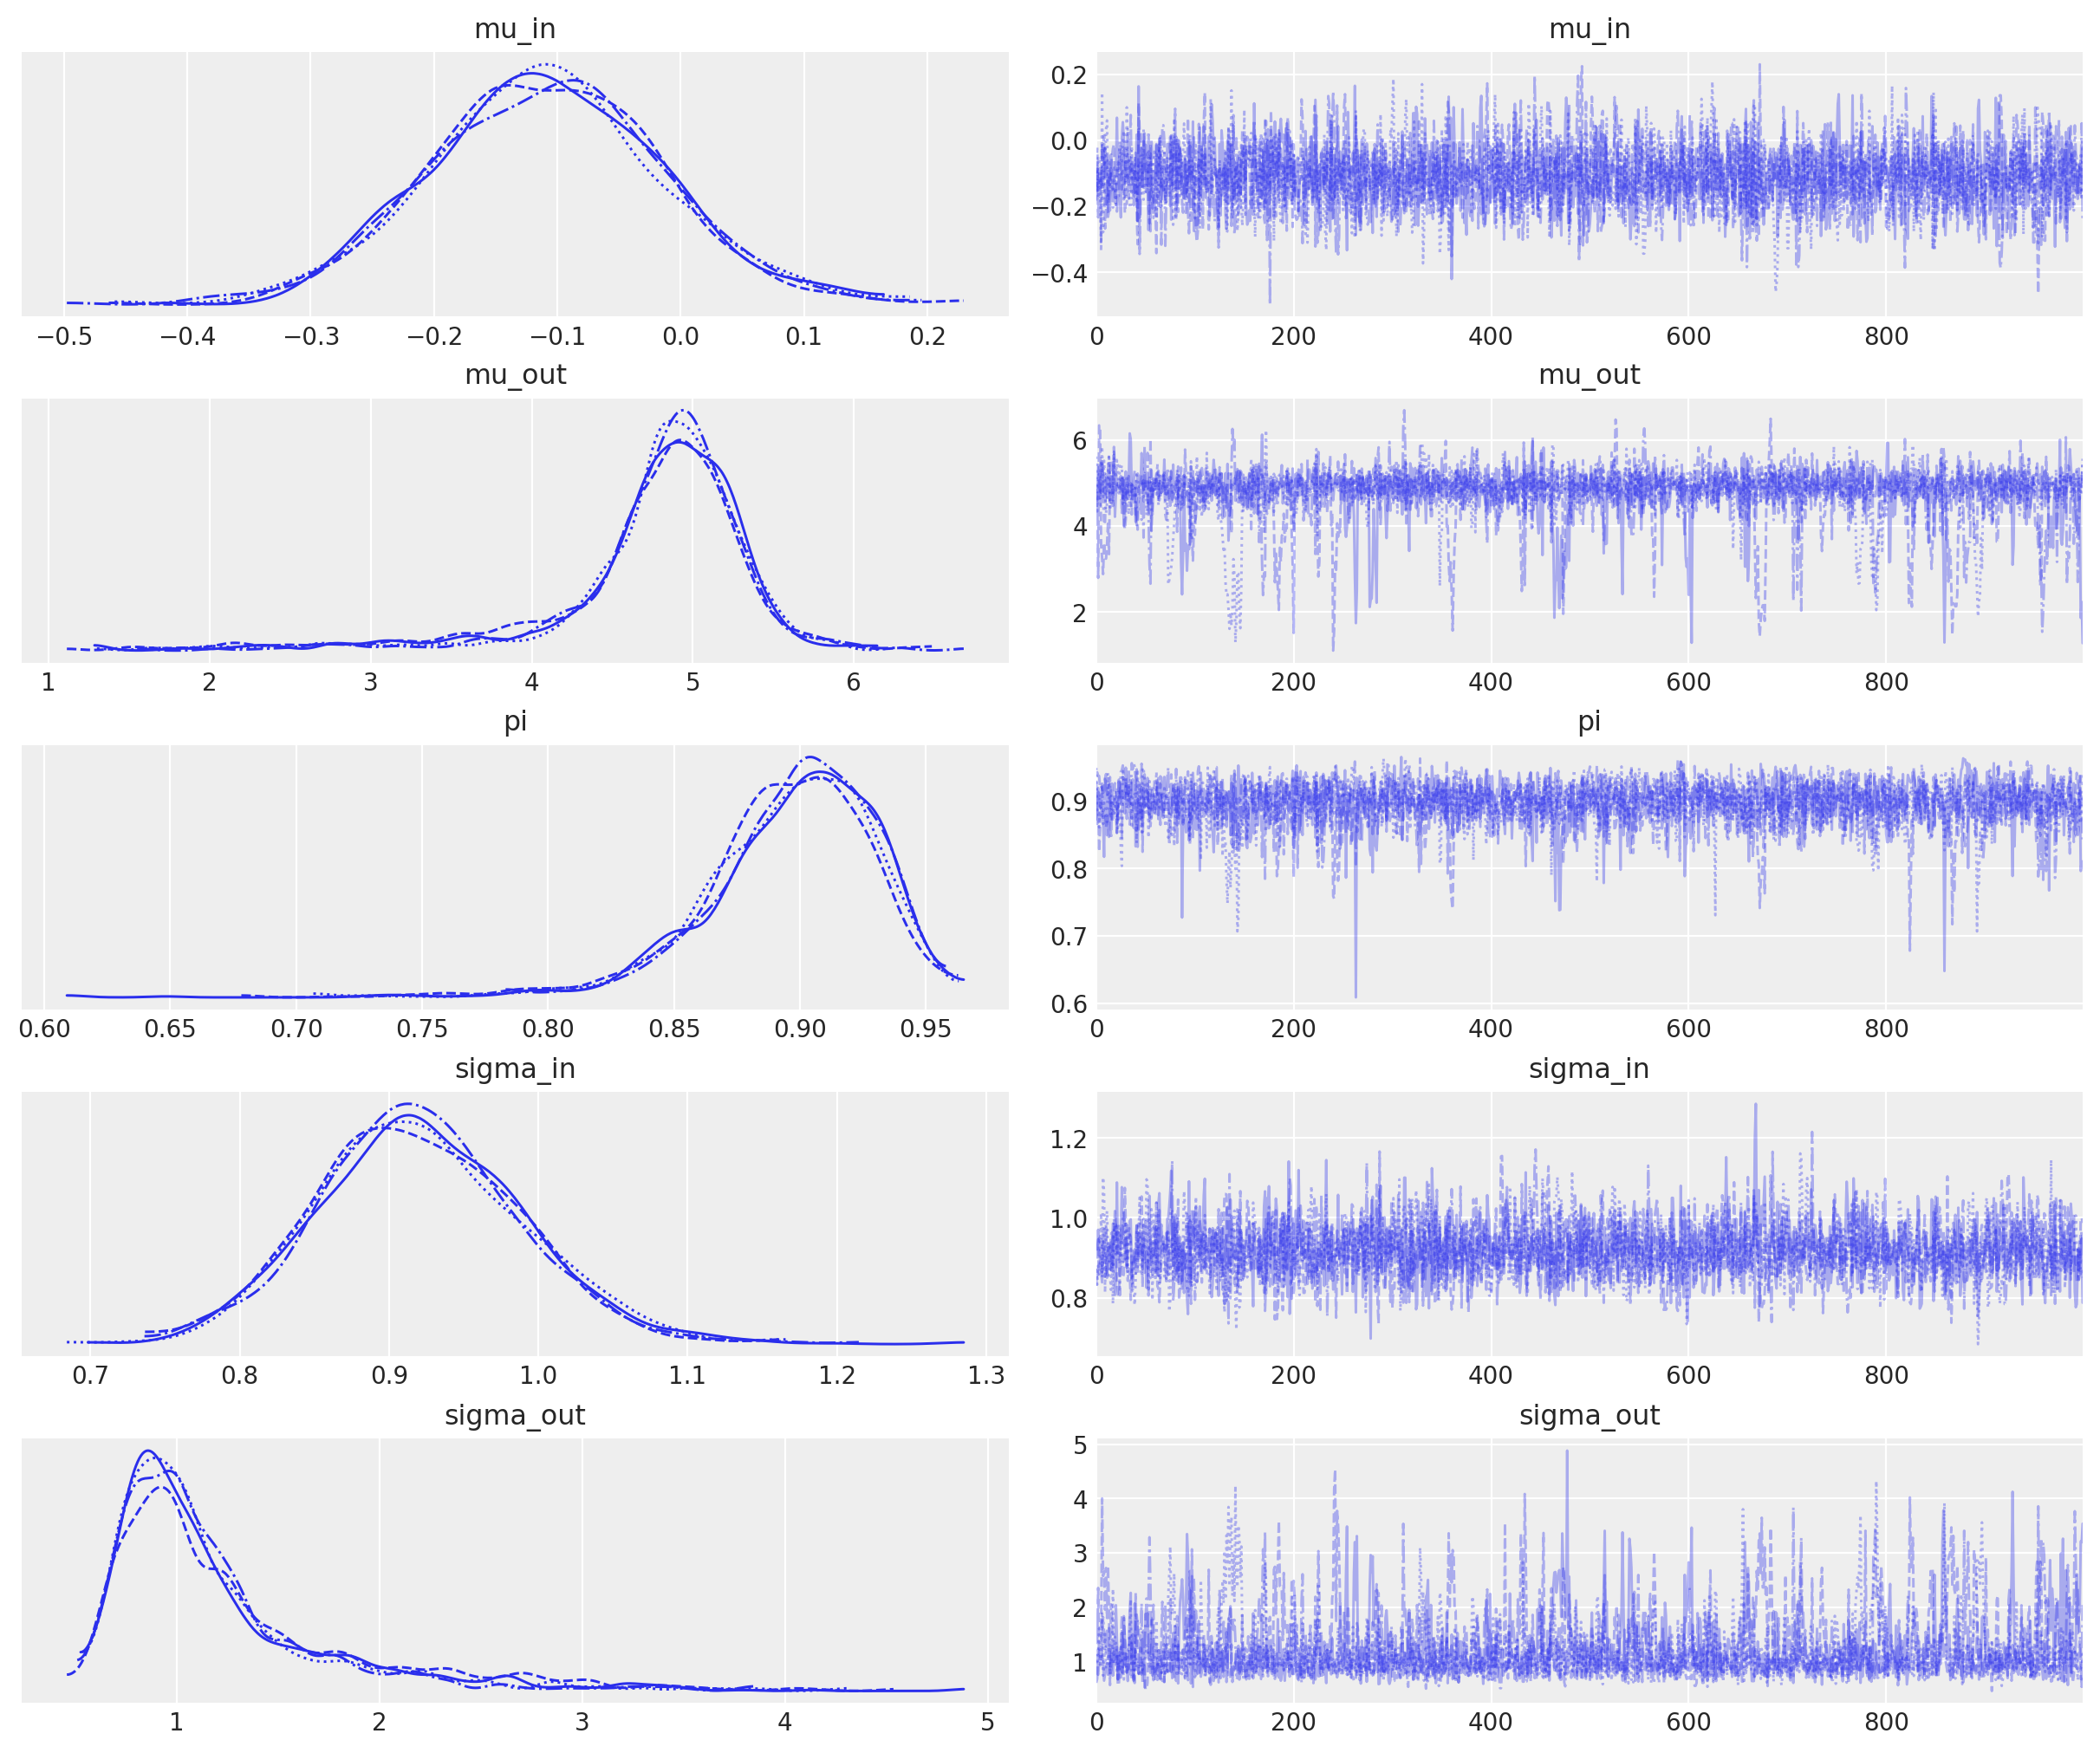

In [11]:
# Use ArviZ to plot posterior distributions of the parameters
az.plot_trace(trace)
plt.show()

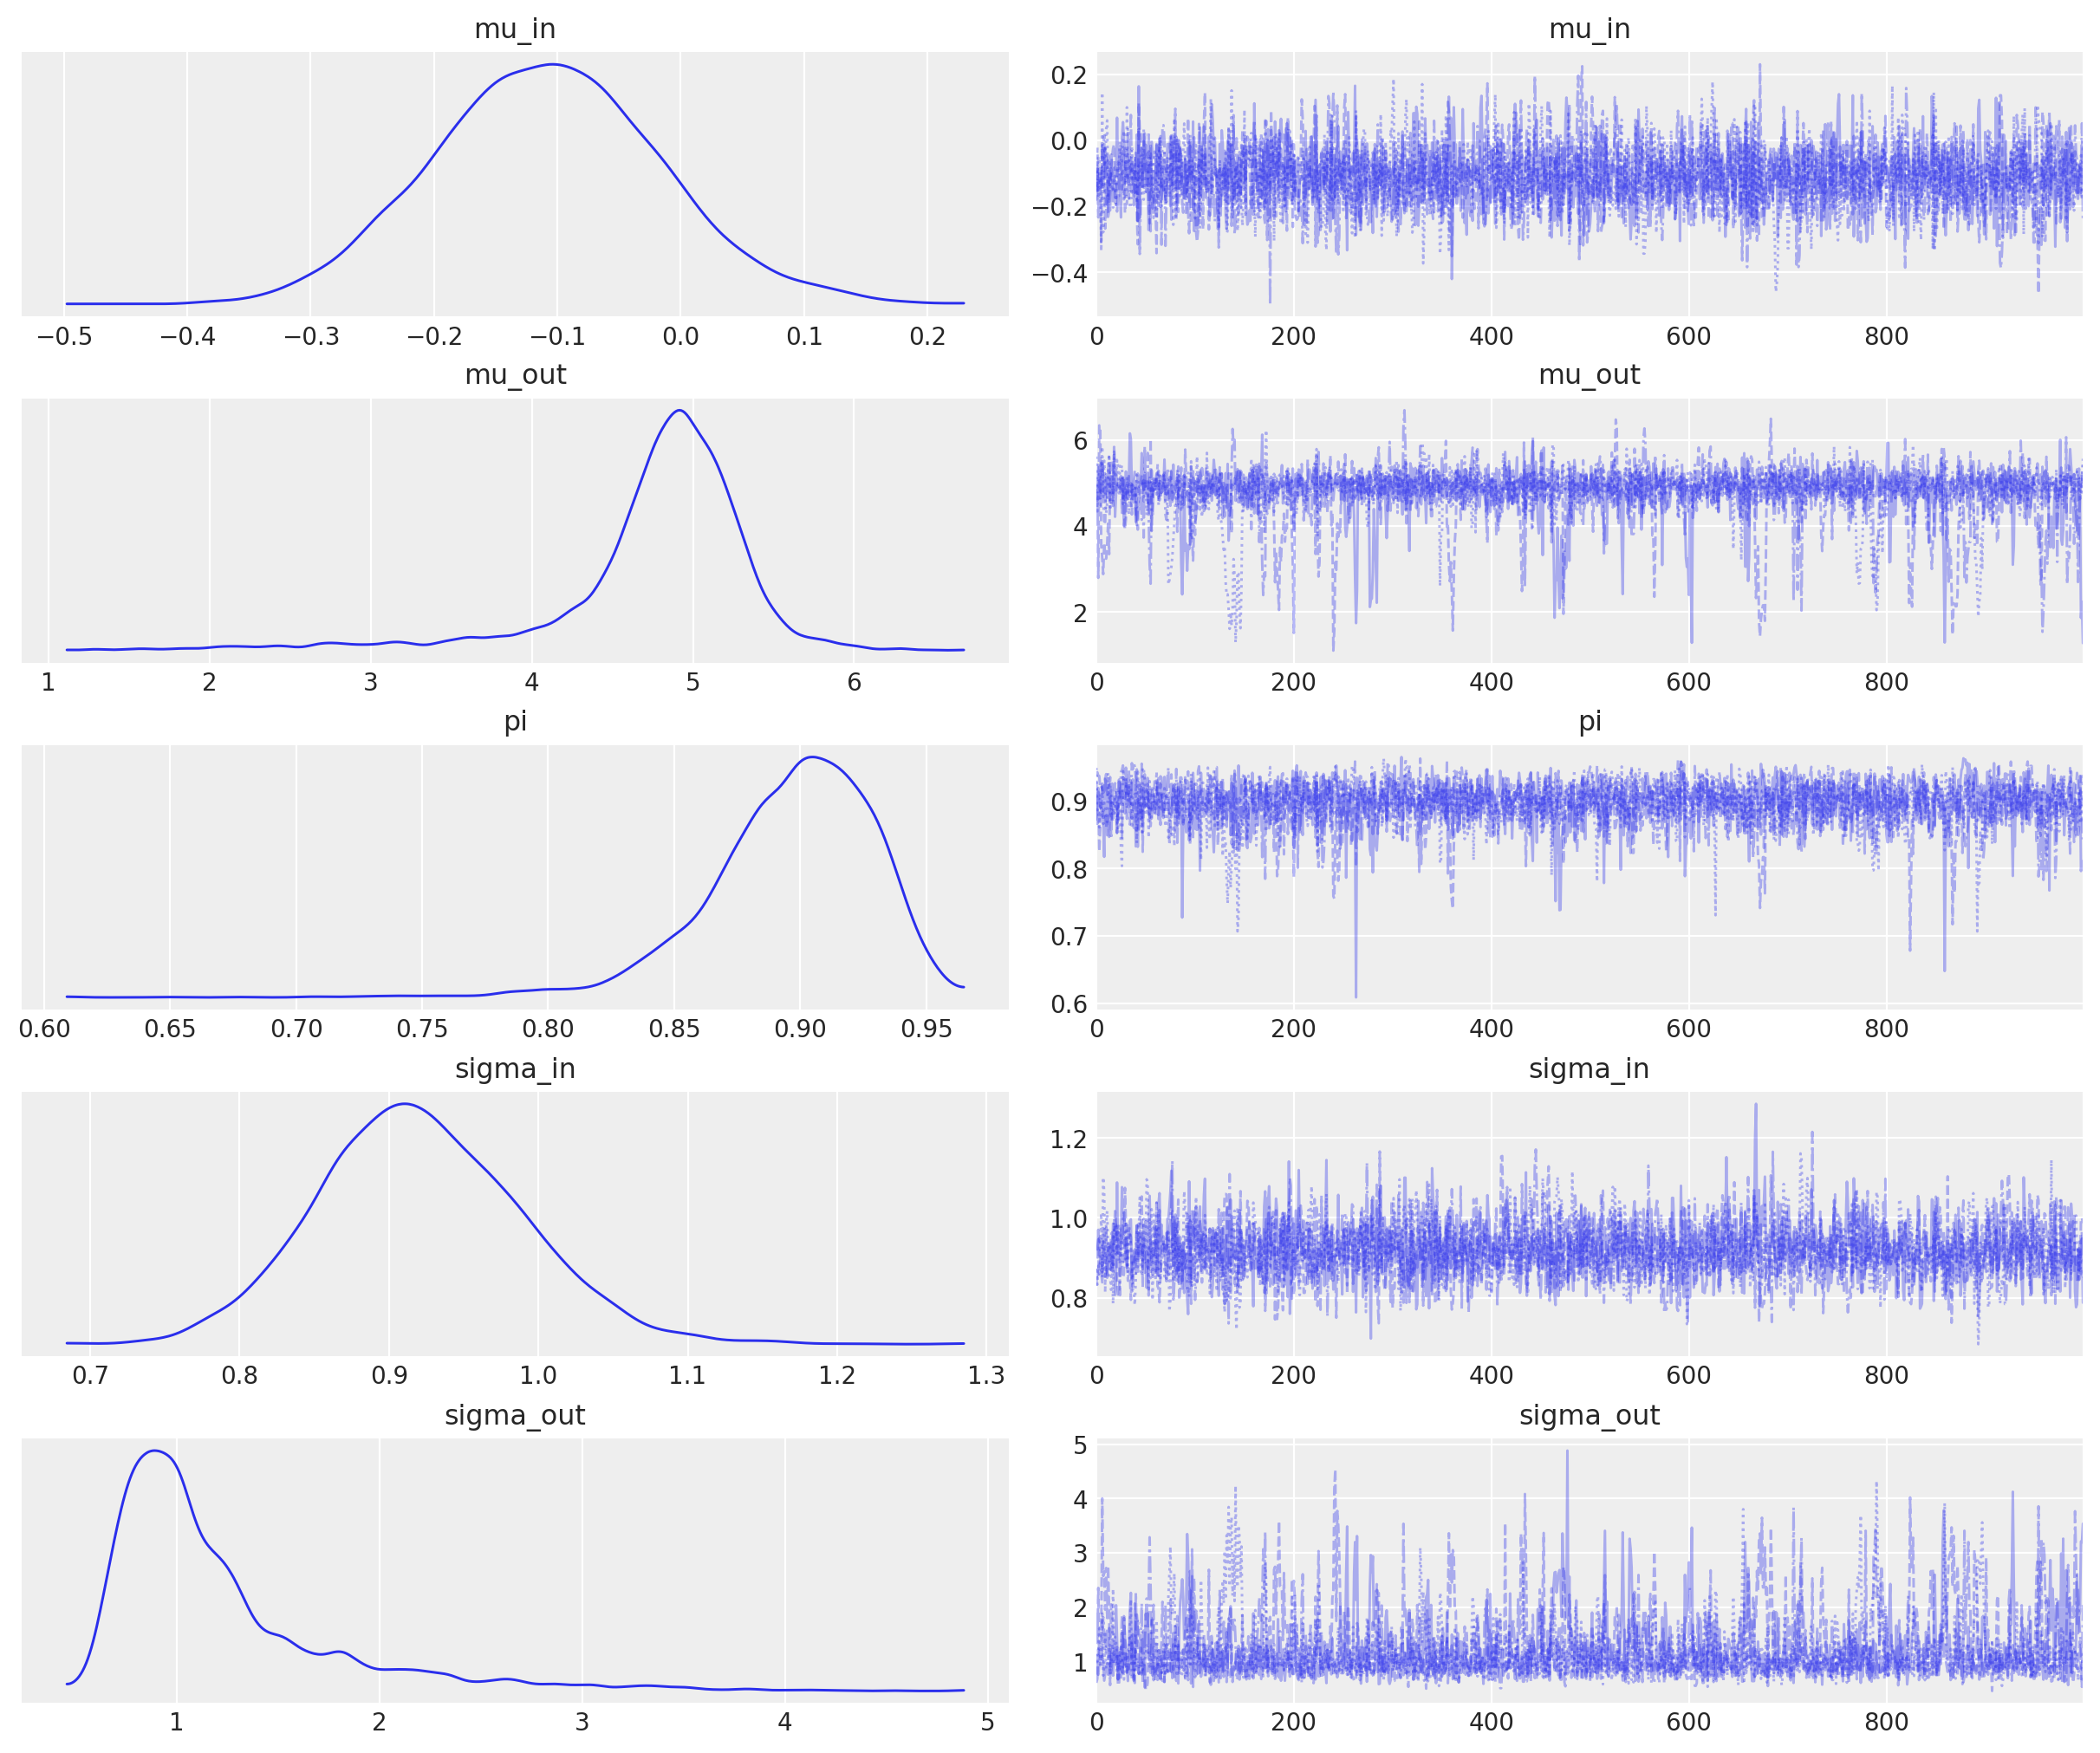

In [12]:
az.plot_trace(trace, combined=True);

In [13]:
# Posterior predictive check
with model:
    posterior_pred = pm.sample_posterior_predictive(trace)

Sampling: [mixture]


Output()

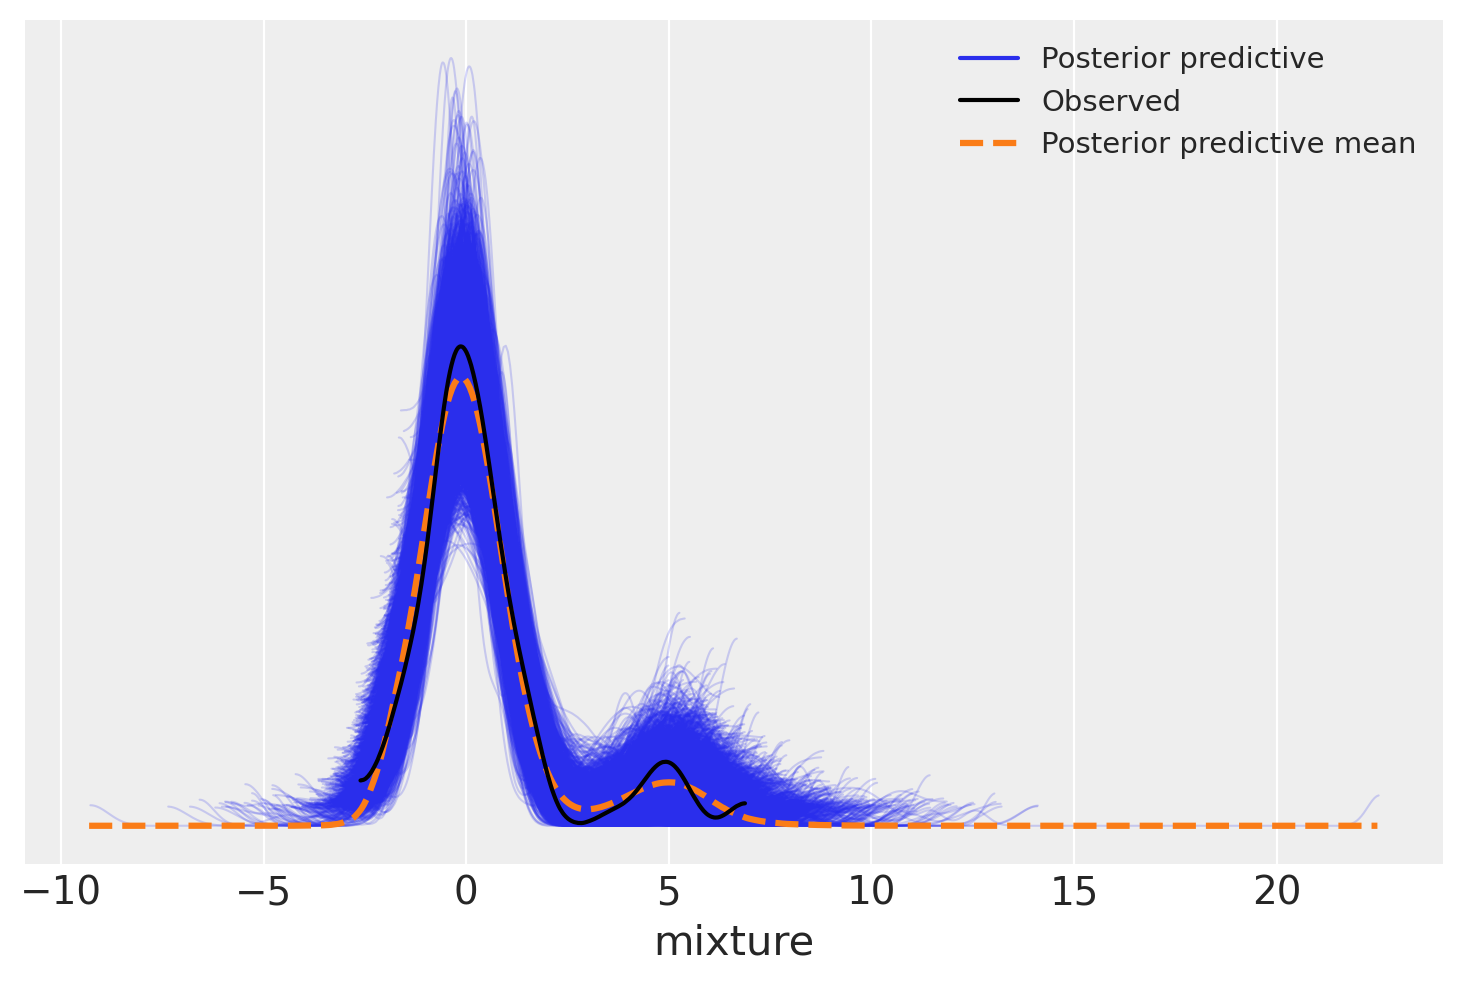

In [14]:
# ArviZ for posterior predictive plotting
#az.plot_ppc(az.from_pymc3(posterior_predictive=posterior_pred, model=model))
az.plot_ppc(posterior_pred)
plt.show()


In [15]:
# Outlier detection: calculate probability of each point being an inlier
# Use the mixture weight `pi` from the posterior
posterior_means = az.summary(trace)
inlier_prob = posterior_means.loc['pi', 'mean']  # Mean probability of being an inlier

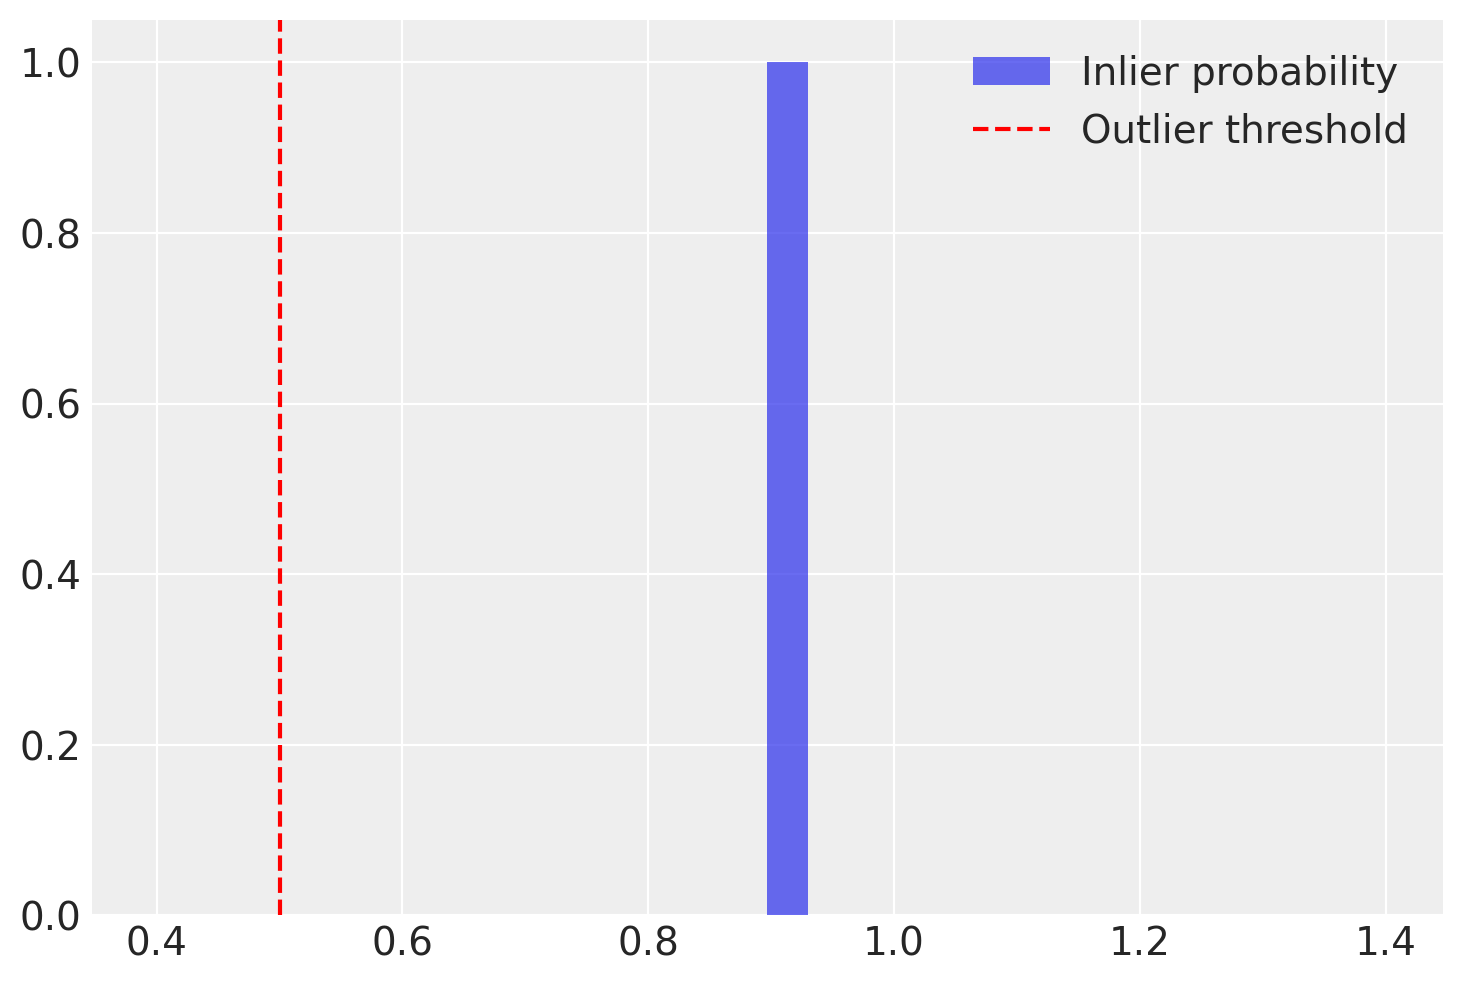

In [16]:
# Classify data points as inliers/outliers based on a threshold (e.g., 0.5)
outlier_threshold = 0.5
plt.hist(inlier_prob, bins=30, alpha=0.7, label="Inlier probability")
plt.axvline(outlier_threshold, color='red', linestyle='--', label="Outlier threshold")
plt.legend()
plt.show()

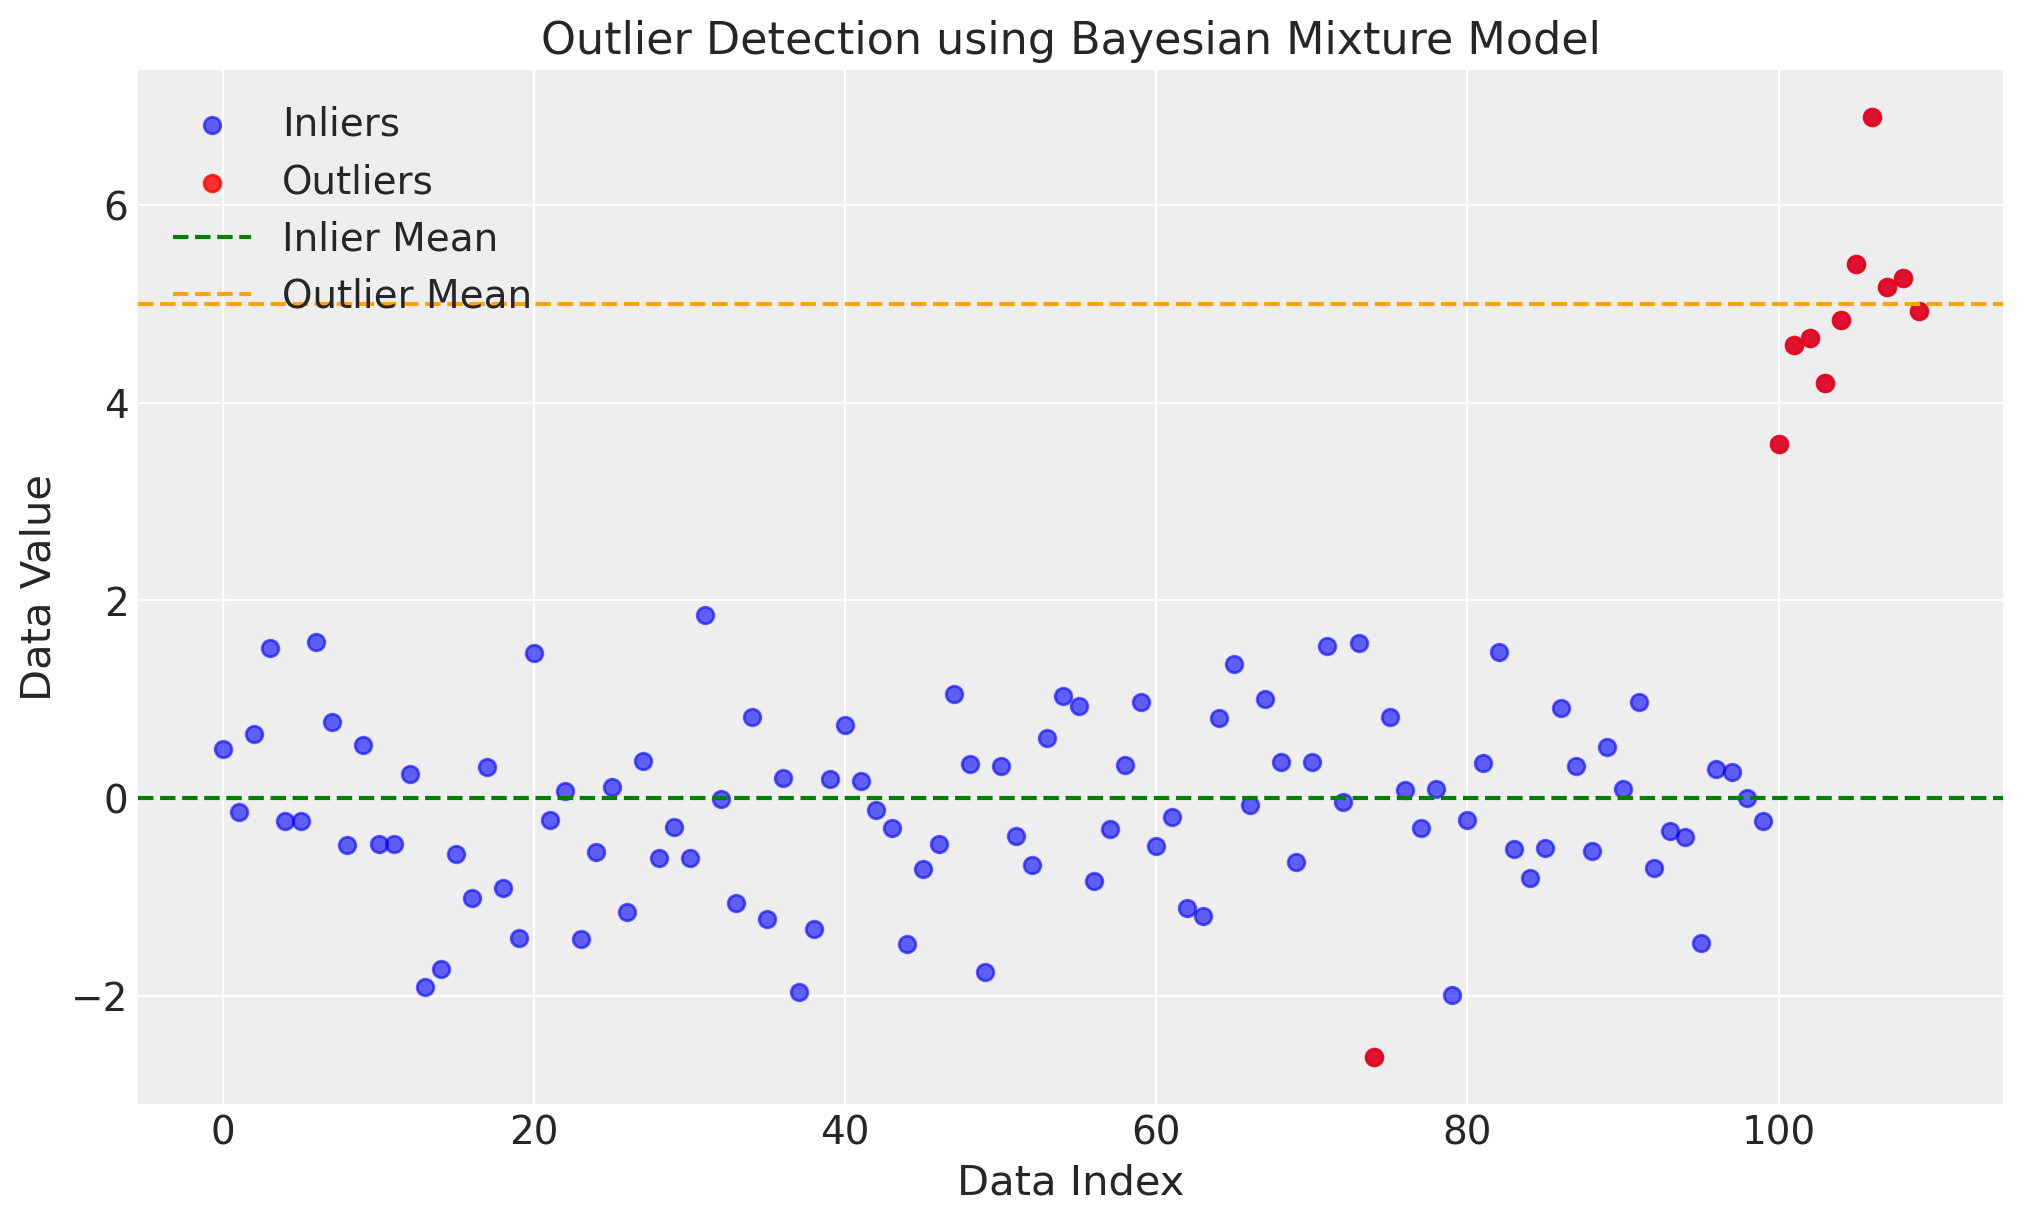

In [17]:
# Create a mask for outliers (points with a low probability of being inliers)
outlier_mask = (data > mu_outlier - 2 * sigma_outlier) | (data < mu_inlier - 2 * sigma_inlier)

# Plot the data points, highlighting outliers
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(data)), data, color='blue', label='Inliers', alpha=0.6)

# Highlight outliers in red
plt.scatter(np.arange(len(data))[outlier_mask], data[outlier_mask], color='red', label='Outliers', alpha=0.8)

plt.axhline(y=mu_inlier, color='green', linestyle='--', label='Inlier Mean')
plt.axhline(y=mu_outlier, color='orange', linestyle='--', label='Outlier Mean')
plt.title('Outlier Detection using Bayesian Mixture Model')
plt.xlabel('Data Index')
plt.ylabel('Data Value')
plt.legend()
plt.show()